## Refs

Follow notebook `cat_dog_transfer_learning.ipynb`

In [ ]:
from google.colab import drive
# drive.mount('/content/drive')
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [1]:
!ls drive/MyDrive/ML_colab/

dataset  datasetbeach_mountain	pretrained  save


In [2]:
import os

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [3]:
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [4]:
# local_weights_file = '../pretrained/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
local_weights_file = 'drive/MyDrive/ML_colab/pretrained/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

In [5]:
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model.load_weights(local_weights_file)

for layer in pre_trained_model.layers:
    layer.trainable = False

# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [30]:
# vgg16 places365 pretrained
local_weights_file_vgg = 'drive/MyDrive/ML_colab/pretrained/vgg16-places365_weights_tf_dim_ordering_tf_kernels_notop.h5'
from tensorflow.keras.applications.vgg16 import VGG16

pre_trained_model_vgg = VGG16(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = None)

pre_trained_model_vgg.load_weights(local_weights_file_vgg)

for layer in pre_trained_model_vgg.layers:
    layer.trainable = False

# pre_trained_model_vgg.summary()

last_layer_vgg = pre_trained_model_vgg.get_layer('block5_conv3')
print('last layer output shape: ', last_layer_vgg.output_shape)
last_output = last_layer_vgg.output

last layer output shape:  (None, 9, 9, 512)


In [32]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (1, activation='sigmoid')(x)           

# model = Model( pre_trained_model.input, x) 
model = Model( pre_trained_model_vgg.input, x) 

model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'binary_crossentropy', 
              metrics = ['accuracy'])

In [ ]:
# !mv drive/MyDrive/ML_colab/datasetbeach_mountain/beach_mountain drive/MyDrive/ML_colab/dataset/

In [7]:
import zipfile

dataset_dir = 'drive/MyDrive/ML_colab/dataset'
zip_file = dataset_dir + '/beach_mountain.zip'
zip_ref = zipfile.ZipFile(zip_file, 'r')
zip_ref.extractall(dataset_dir+'/b_m')
zip_ref.close()

In [10]:
# !ls drive/MyDrive/ML_colab/dataset/b_m/beach_mountain/

train  validation


In [ ]:
# %%time
# import zipfile

# dataset_dir = 'drive/MyDrive/ML_colab/dataset'
# zip_file = dataset_dir + '/beach_mountain.zip'
# zip_ref = zipfile.ZipFile(zip_file, 'r')
# zip_ref.extractall("/tmp")
# zip_ref.close()

In [11]:
# local data

# base_dir = "../dataset/beach_mountain"
# base_dir = "drive/MyDrive/ML_colab/dataset/beach_mountain"
base_dir = "drive/MyDrive/ML_colab/dataset/b_m/beach_mountain/"

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

train_beach_dir = os.path.join(train_dir, 'beach')
train_moutain_dir = os.path.join(train_dir, 'mountain')

validation_beach_dir = os.path.join(validation_dir, 'beach')
validation_mountain_dir = os.path.join(validation_dir, 'mountain')

train_beach_fnames = os.listdir(train_beach_dir)
train_mountain_fnames = os.listdir(train_moutain_dir)

In [12]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   rotation_range = 40,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1.0/255.)

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size = 20,
                                                    class_mode = 'binary', 
                                                    target_size = (150, 150))

validation_generator =  test_datagen.flow_from_directory(validation_dir,
                                                         batch_size  = 20,
                                                         class_mode  = 'binary', 
                                                         target_size = (150, 150))

Found 9000 images belonging to 2 classes.
Found 1200 images belonging to 2 classes.


In [33]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy') is not None and logs.get('accuracy') > 0.96) :
            print("\nReached 97.0% accuracy so cancelling training!")
            self.model.stop_training = True

my_callback = myCallback()

In [34]:
history = model.fit(
            train_generator,
            validation_data = validation_generator,
            steps_per_epoch = 100,
            epochs = 100,
            validation_steps = 50,
            verbose = 2,
            callbacks=[my_callback])

Epoch 1/100
100/100 - 21s - loss: 0.7813 - accuracy: 0.6965 - val_loss: 0.6310 - val_accuracy: 0.6940
Epoch 2/100
100/100 - 19s - loss: 0.5553 - accuracy: 0.7325 - val_loss: 0.3409 - val_accuracy: 0.8710
Epoch 3/100
100/100 - 18s - loss: 0.4950 - accuracy: 0.7760 - val_loss: 0.3094 - val_accuracy: 0.8840
Epoch 4/100
100/100 - 19s - loss: 0.4953 - accuracy: 0.7865 - val_loss: 0.3182 - val_accuracy: 0.8780
Epoch 5/100
100/100 - 18s - loss: 0.4335 - accuracy: 0.8110 - val_loss: 0.3310 - val_accuracy: 0.8700
Epoch 6/100
100/100 - 18s - loss: 0.4488 - accuracy: 0.8075 - val_loss: 0.3499 - val_accuracy: 0.8580
Epoch 7/100
100/100 - 19s - loss: 0.4141 - accuracy: 0.8205 - val_loss: 0.3064 - val_accuracy: 0.8790
Epoch 8/100
100/100 - 19s - loss: 0.4499 - accuracy: 0.8045 - val_loss: 0.3367 - val_accuracy: 0.8790
Epoch 9/100
100/100 - 19s - loss: 0.3918 - accuracy: 0.8250 - val_loss: 0.3628 - val_accuracy: 0.8750
Epoch 10/100
100/100 - 18s - loss: 0.3998 - accuracy: 0.8305 - val_loss: 0.3070 - 

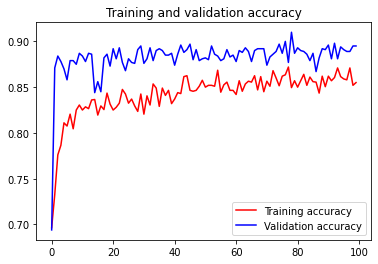

<Figure size 432x288 with 0 Axes>

In [35]:
%matplotlib inline
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()
plt.show()

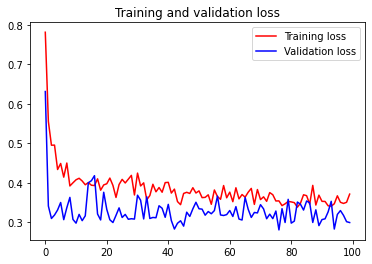

<Figure size 432x288 with 0 Axes>

In [38]:
epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()
plt.show()

In [36]:
saved_model_path = ""
model.save("drive/MyDrive/ML_colab/save/beach_mountain/100epochs/SavedModel_pre_vgg16_100e")

INFO:tensorflow:Assets written to: drive/MyDrive/ML_colab/save/beach_mountain/100epochs/SavedModel_pre_vgg16_100e/assets


In [37]:
model.save("drive/MyDrive/ML_colab/save/beach_mountain/100epochs/model_pre_vgg16_100e.h5")

In [23]:
# keep colab alive
while True:pass

KeyboardInterrupt: ignored